In [81]:
from pathlib import Path

import numpy as np
import pandas as pd
import jsonpickle

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [35]:
RUNDIR = "../output"
RUNID = "20240216_142555"

In [36]:
config_files = list(Path(RUNDIR).glob(f"{RUNID}*.config.json"))
print(f"Found {len(config_files)} config files")

Found 25 config files


In [37]:
configs = {}
dfs = {}
for config_file in config_files:
    config = jsonpickle.decode(config_file.read_text())
    data_file = Path(RUNDIR, config_file.name.split(".")[0] + ".csv")
    sub_id = config_file.name.split(".")[0].split("_")[-1]
    
    data = pd.read_csv(data_file)
    data["id"] = sub_id
    data["algorithm"] = config["algorithm"]
    data["dataset"] = config["dataset"]
    data["imbalance"] = config["imbalance_type"]
    data["imbalance_val"] = config["imbalance_value"]
    data["is_last_round"] = data["round"] == (config["rounds"] - 1)
    
    if sub_id in configs:
        print("Duplicate id!")
    dfs[sub_id] = data
    configs[sub_id] = config
    
data = pd.concat(dfs.values(), axis=0)
cluster_assignments = data.query("stage == 'test' and variable == 'cluster_identities'") 
data = data.query("variable != 'cluster_identities'")
data["value"] = data["value"].astype(float)

In [38]:
configs["0"]

{'algorithm': 'FedAvg',
 'dataset': 'cifar10',
 'rounds': 130,
 'epochs': 10,
 'n_clients': 100,
 'clients_per_round': 1.0,
 'imbalance_type': 'label_distribution',
 'imbalance_value': 0.1,
 'penalty': 0}

In [39]:
data["variable"].unique()

array(['loss', 'n_samples', 'f1'], dtype=object)

In [40]:
data = data.pivot_table(values = "value", index = ["round", "client", "stage", "id", "algorithm", "dataset", "imbalance", "imbalance_val", "is_last_round"], columns = ["variable"]).reset_index()
data.head()

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
0,0,0,test,1,local,cifar10,iid,1.0,False,0.051479,0.046150,100.0
1,0,0,test,10,IFCA,cifar10,label_distribution,0.5,False,0.075472,2.168168,148.0
2,0,0,test,11,local,cifar10,label_distribution,0.5,False,0.075472,0.039892,148.0
3,0,0,test,13,IFCA,cifar10,label_distribution,5.0,False,0.031783,2.287164,112.0
4,0,0,test,15,FLSC,cifar10,label_distribution,1.0,False,0.049485,2.304974,58.0


In [41]:
df = data.query("stage == 'test' and algorithm == 'FedProx'")
df["weighted_f1"] = df["f1"] * df["n_samples"]
df["weighted_loss"] = df["loss"] * df["n_samples"]
df = df.drop(columns=["client", "stage", "id", "dataset", "imbalance", "is_last_round", "algorithm"])\
    .groupby(["round", "imbalance_val"])\
    .sum()\
    .reset_index()

df["weighted_f1"] = df["weighted_f1"] / df["n_samples"]
df["weighted_loss"] = df["weighted_loss"] / df["n_samples"]

df = df.drop(columns=["loss", "f1"])
df

/tmp/ipykernel_5027/3625245082.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_5027/3625245082.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



variable,round,imbalance_val,n_samples,weighted_f1,weighted_loss
0,1,0.1,6278.0,0.341968,0.794510
1,1,0.5,6861.0,0.210516,1.422874
2,1,1.0,13002.0,0.216845,1.792340
3,1,5.0,6747.0,0.226397,1.817914
4,2,0.1,5865.0,0.397106,0.600329
...,...,...,...,...,...
515,129,5.0,6239.0,0.364175,2.229207
516,130,0.1,7164.0,0.438664,0.607089
517,130,0.5,6773.0,0.373046,1.164782
518,130,1.0,11410.0,0.343517,2.050726


<Axes: xlabel='round', ylabel='weighted_f1'>

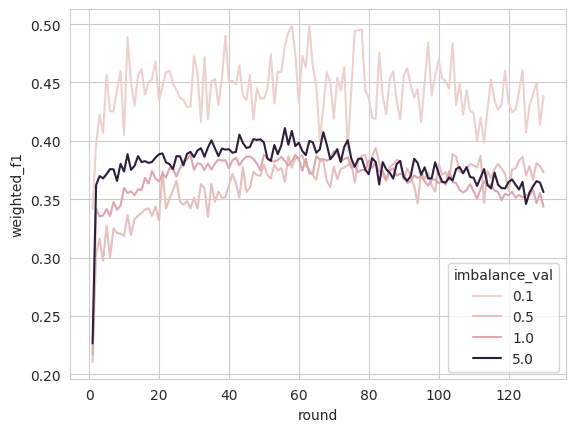

In [42]:
sns.lineplot(df, x = "round", y="weighted_f1", hue="imbalance_val")

<Axes: xlabel='round', ylabel='weighted_loss'>

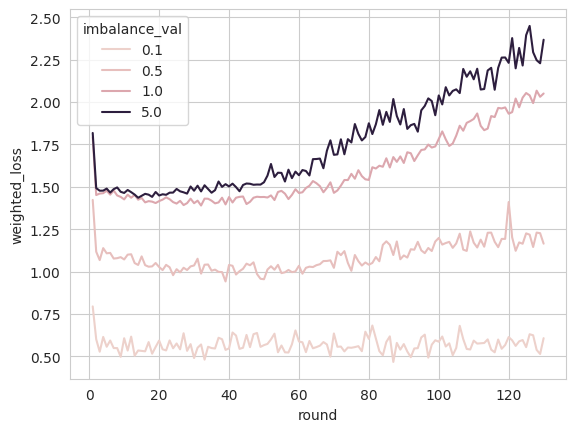

In [43]:
sns.lineplot(df, x = "round", y="weighted_loss", hue="imbalance_val")

<Axes: xlabel='round', ylabel='loss'>

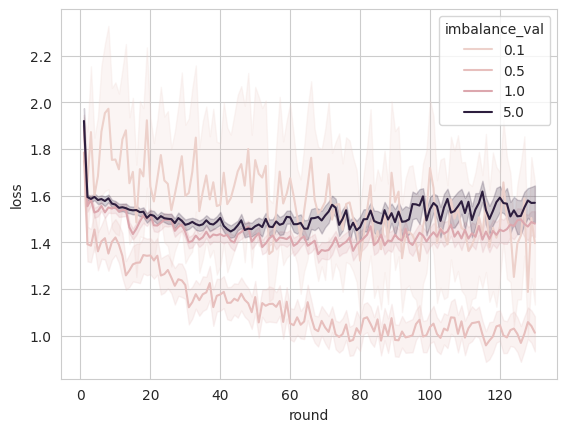

In [44]:
df = data.query("stage == 'train' and algorithm == 'FedAvg'")
sns.lineplot(df, x = "round", y = "loss", hue = "imbalance_val")

<Axes: xlabel='round', ylabel='f1'>

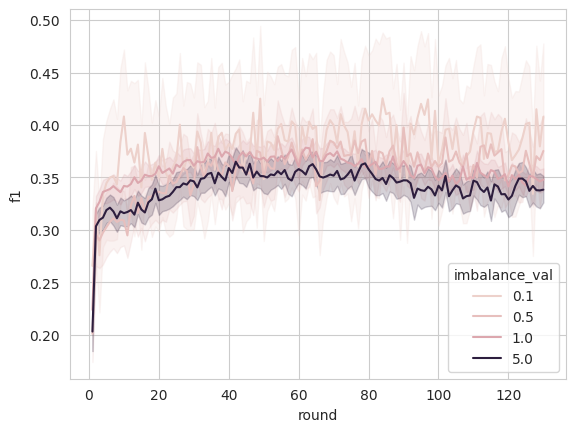

In [45]:
df = data.query("stage == 'test' and algorithm == 'FedAvg'")
sns.lineplot(df, x = "round", y = "f1", hue = "imbalance_val")

In [46]:
df_last = data.query("stage == 'test' and is_last_round")
df_last

variable,round,client,stage,id,algorithm,dataset,imbalance,imbalance_val,is_last_round,f1,loss,n_samples
549376,129,0,test,0,FedAvg,cifar10,label_distribution,0.1,True,0.233557,1.664064,74.0
549377,129,0,test,1,local,cifar10,iid,1.0,True,0.360539,0.053439,100.0
549378,129,0,test,10,IFCA,cifar10,label_distribution,0.5,True,0.230308,1.722680,148.0
549379,129,0,test,11,local,cifar10,label_distribution,0.5,True,0.325265,0.044725,148.0
549380,129,0,test,12,FedProx,cifar10,label_distribution,0.1,True,0.257867,1.401473,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...
553642,129,99,test,4,IFCA,cifar10,label_distribution,1.0,True,0.352549,2.320435,106.0
553643,129,99,test,5,local,cifar10,label_distribution,0.1,True,0.918043,0.008603,166.0
553644,129,99,test,6,FedAvg,cifar10,iid,1.0,True,0.375616,2.690716,100.0
553645,129,99,test,7,IFCA,cifar10,label_distribution,0.1,True,0.937434,0.214776,166.0


Text(0.5, 1.0, 'Avg. F1 scores by imbalance param')

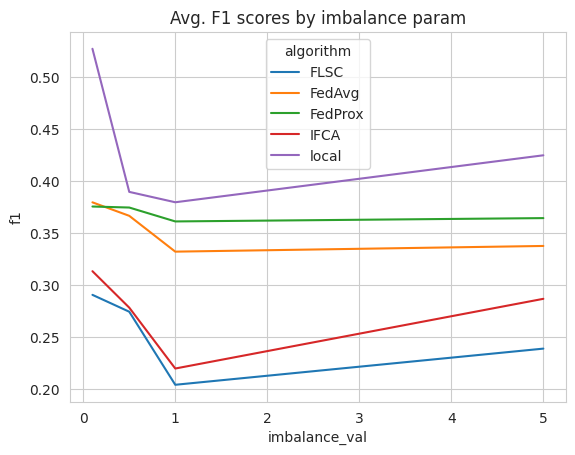

In [47]:
df_last_avg = df_last.groupby(["imbalance", "imbalance_val", "algorithm"]).mean(["f1", "loss"]).reset_index()\
    .query("imbalance == 'label_distribution'")
sns.lineplot(df_last_avg, x="imbalance_val", y="f1", hue='algorithm')
plt.title("Avg. F1 scores by imbalance param")

In [48]:
algorithms = set(df_last["algorithm"].unique()).difference({"local", "global"})
benefits = df_last.reset_index(drop=True)[["stage", "round", "client", "algorithm", "dataset", "imbalance", "imbalance_val", "f1"]]
benefits = benefits.pivot(columns="algorithm", values="f1", index=["stage", "round", "client", "dataset", "imbalance", "imbalance_val"]).reset_index()
benefits

algorithm,stage,round,client,dataset,imbalance,imbalance_val,FLSC,FedAvg,FedProx,IFCA,local
0,test,129,0,cifar10,iid,1.0,0.266801,0.363892,0.288470,0.259275,0.360539
1,test,129,0,cifar10,label_distribution,0.1,0.037879,0.233557,0.257867,0.035088,0.576009
2,test,129,0,cifar10,label_distribution,0.5,0.234825,0.394629,NaN,0.230308,0.325265
3,test,129,0,cifar10,label_distribution,1.0,0.168323,0.244216,0.301328,0.159969,0.233157
4,test,129,0,cifar10,label_distribution,5.0,0.224775,0.165391,NaN,0.299600,0.357494
...,...,...,...,...,...,...,...,...,...,...,...
495,test,129,99,cifar10,iid,1.0,0.342171,0.375616,NaN,0.334284,0.436735
496,test,129,99,cifar10,label_distribution,0.1,0.937434,0.931649,NaN,0.937434,0.918043
497,test,129,99,cifar10,label_distribution,0.5,0.242796,NaN,0.292734,0.288674,0.381061
498,test,129,99,cifar10,label_distribution,1.0,0.373114,NaN,0.397151,0.352549,0.393764


In [49]:
local = df_last.query("algorithm == 'local'")[["client","imbalance","imbalance_val","f1"]]
fedavg = df_last.query("algorithm == 'FedAvg'")[["client","imbalance","imbalance_val","f1"]]
fedprox = df_last.query("algorithm == 'FedProx'")[["client","imbalance","imbalance_val","f1"]]
ifca = df_last.query("algorithm == 'IFCA'")[["client","imbalance","imbalance_val","f1"]]
flsc = df_last.query("algorithm == 'FLSC'")[["client","imbalance","imbalance_val","f1"]]

In [50]:
f1scores = ifca.merge(flsc, on=["client", "imbalance", "imbalance_val"], suffixes=["_ifca", "_flsc"])\
    .merge(fedavg, on=["client", "imbalance", "imbalance_val"])\
    .merge(local, on=["client", "imbalance", "imbalance_val"], suffixes=["_fedavg", "_local"])\
    .merge(fedprox, on=["client", "imbalance", "imbalance_val"])\
    .rename(columns={"f1": "f1_fedprox"})
f1scores = f1scores.query("imbalance == 'label_distribution'")
f1scores

variable,client,imbalance,imbalance_val,f1_ifca,f1_flsc,f1_fedavg,f1_local,f1_fedprox
1,0,label_distribution,1.0,0.159969,0.168323,0.244216,0.233157,0.301328
2,0,label_distribution,0.1,0.035088,0.037879,0.233557,0.576009,0.257867
3,2,label_distribution,0.5,0.205442,0.712288,0.637978,0.243952,0.260000
4,2,label_distribution,1.0,0.151359,0.159710,0.326074,0.209286,0.260504
5,3,label_distribution,0.5,0.378651,0.392986,0.521674,0.521972,0.532692
...,...,...,...,...,...,...,...,...
203,97,label_distribution,1.0,0.289454,0.193706,0.513084,0.459465,0.329845
204,97,label_distribution,0.1,0.490654,0.323899,0.488263,0.325509,0.320635
205,98,label_distribution,0.5,0.259128,0.235936,0.417263,0.535107,0.427616
206,98,label_distribution,0.1,0.278414,0.331143,0.494010,0.346891,0.531079


In [51]:
f1scores["benefit_fedavg"] = f1scores["f1_fedavg"] - f1scores["f1_local"]
f1scores["benefit_fedprox"] = f1scores["f1_fedprox"] - f1scores["f1_local"]
f1scores["benefit_ifca"] = f1scores["f1_ifca"] - f1scores["f1_local"]
f1scores["benefit_flsc"] = f1scores["f1_flsc"] - f1scores["f1_local"]

In [52]:
benefits = f1scores.drop(columns=["f1_local", "f1_fedavg", "f1_ifca", "f1_flsc", "f1_fedprox"]).melt(id_vars=["client", "imbalance", "imbalance_val"], value_name="client_benefit", var_name="algorithm")

<Axes: xlabel='client_benefit', ylabel='Count'>

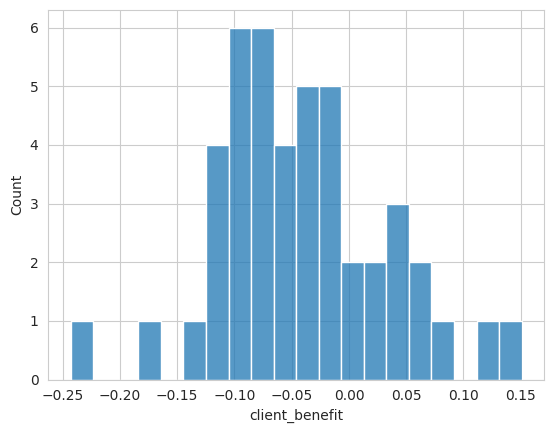

In [53]:
sns.histplot(benefits.query("algorithm == 'benefit_fedavg' and imbalance_val == 1"), x = "client_benefit", bins=20)

In [54]:
avg_benefits = benefits.groupby(["imbalance", "imbalance_val", "algorithm"]).mean().reset_index()
avg_benefits

,imbalance,imbalance_val,algorithm,client,client_benefit
0,label_distribution,0.1,benefit_fedavg,49.673913,-0.131346
1,label_distribution,0.1,benefit_fedprox,49.673913,-0.157380
2,label_distribution,0.1,benefit_flsc,49.673913,-0.221961
3,label_distribution,0.1,benefit_ifca,49.673913,-0.207710
4,label_distribution,0.5,benefit_fedavg,55.743590,-0.035253
5,label_distribution,0.5,benefit_fedprox,55.743590,-0.022689
6,label_distribution,0.5,benefit_flsc,55.743590,-0.137158
7,label_distribution,0.5,benefit_ifca,55.743590,-0.133330
8,label_distribution,1.0,benefit_fedavg,48.755556,-0.041003
9,label_distribution,1.0,benefit_fedprox,48.755556,-0.026248


<Axes: xlabel='imbalance_val', ylabel='client_benefit'>

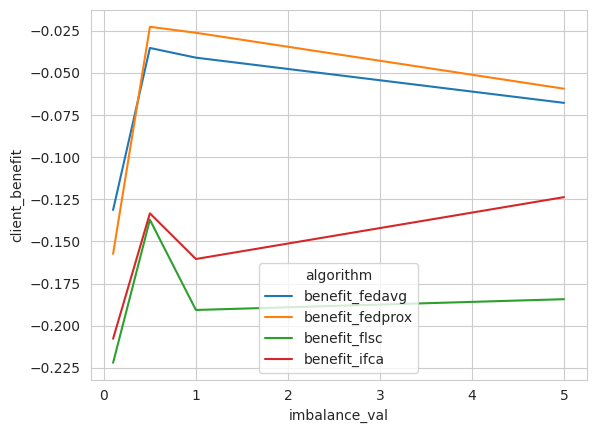

In [55]:
sns.lineplot(avg_benefits, x="imbalance_val", y="client_benefit", hue="algorithm")

## Benefit per Client

In [85]:
dataset = "cifar10"
imbalance = "label_distribution"
imbalance_val = 5
df = f1scores.query(f"imbalance == '{imbalance}' and imbalance_val < {imbalance_val}")
# df = f1scores.query(f"imbalance == '{imbalance}'")
imbalances = pd.read_csv(Path(RUNDIR, RUNID + "_data.csv"))
df = df.merge(imbalances)
df.head()

,client,imbalance,imbalance_val,f1_ifca,f1_flsc,f1_fedavg,f1_local,f1_fedprox,benefit_fedavg,benefit_fedprox,benefit_ifca,benefit_flsc,dataset,imbalance_type,imbalance_value,label_imbalance,label_distribution_imbalance,quantity_imbalance
0,0,label_distribution,1.0,0.159969,0.168323,0.244216,0.233157,0.301328,0.011059,0.068171,-0.073188,-0.064834,cifar10,label_distribution,0.1,167.00,0.440393,0.748
1,0,label_distribution,1.0,0.159969,0.168323,0.244216,0.233157,0.301328,0.011059,0.068171,-0.073188,-0.064834,cifar10,iid,1.0,1.55,0.006575,1.000
2,0,label_distribution,1.0,0.159969,0.168323,0.244216,0.233157,0.301328,0.011059,0.068171,-0.073188,-0.064834,cifar10,label_distribution,1.0,82.00,0.243454,0.582
3,0,label_distribution,1.0,0.159969,0.168323,0.244216,0.233157,0.301328,0.011059,0.068171,-0.073188,-0.064834,cifar10,label_distribution,0.5,83.75,0.369071,1.486
4,0,label_distribution,1.0,0.159969,0.168323,0.244216,0.233157,0.301328,0.011059,0.068171,-0.073188,-0.064834,cifar10,label_distribution,5.0,84.00,0.081105,1.124


<Axes: xlabel='label_distribution_imbalance', ylabel='benefit_fedavg'>

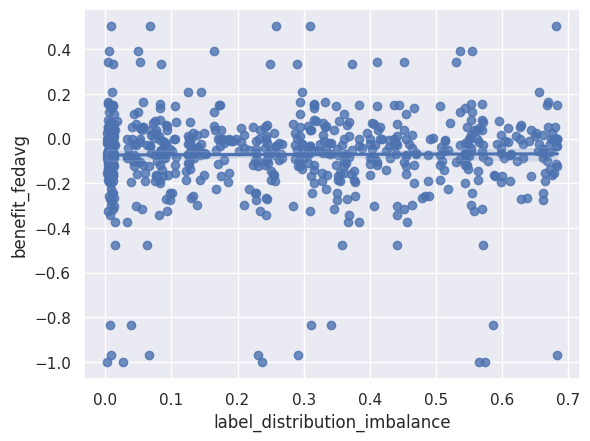

In [86]:
sns.regplot(df, x="label_distribution_imbalance", y="benefit_fedavg")

## Cluster Assignments

In [87]:
n_clusters = 5
cluster_assignments

,round,client,algorithm,imbalance,imbalance_val,clusters
5,0,0,FLSC,label_distribution,0.5,"[1, 0, 0]"
12,0,1,FLSC,label_distribution,0.5,"[3, 3, 0]"
19,0,2,FLSC,label_distribution,0.5,"[1, 0, 3]"
26,0,3,FLSC,label_distribution,0.5,"[0, 3, 3]"
33,0,4,FLSC,label_distribution,0.5,"[0, 1, 2]"
...,...,...,...,...,...,...
90970,129,95,IFCA,iid,1.0,2
90977,129,96,IFCA,iid,1.0,2
90984,129,97,IFCA,iid,1.0,1
90991,129,98,IFCA,iid,1.0,1


In [59]:
def extract_cluster_assignments(ca):
    if isinstance(ca, str):
        return list(map(int, ca.split("|")))
    else:
        return int(ca)

cluster_assignments["clusters"] = cluster_assignments["value"].apply(extract_cluster_assignments)
cluster_assignments = cluster_assignments[["round", "client", "algorithm", "imbalance", "imbalance_val", "clusters"]]

In [60]:
ca_ifca = cluster_assignments.query("algorithm == 'IFCA'")
ca_flsc = cluster_assignments.query("algorithm == 'FLSC'").explode("clusters")

In [61]:
df = ca_ifca.groupby(["round", "algorithm", "imbalance", "imbalance_val", "clusters"]).size().reset_index().rename(columns={0: 'count'})
df

,round,algorithm,imbalance,imbalance_val,clusters,count
0,0,IFCA,iid,1.0,0,25
1,0,IFCA,iid,1.0,1,25
2,0,IFCA,iid,1.0,2,24
3,0,IFCA,iid,1.0,3,26
4,0,IFCA,label_distribution,0.1,0,21
...,...,...,...,...,...,...
2595,129,IFCA,label_distribution,1.0,3,30
2596,129,IFCA,label_distribution,5.0,0,28
2597,129,IFCA,label_distribution,5.0,1,19
2598,129,IFCA,label_distribution,5.0,2,26


In [62]:
import plotly.express as px
import plotly.graph_objects as go

px.area(df.query("imbalance_val == 0.1"), x="round", y="count", color="clusters")

/home/lukas/Work/masterthesis-clustered-fl/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [63]:
px.line(ca_ifca.query("imbalance_val == 0.1"), x="round", y="clusters", color="client")

/home/lukas/Work/masterthesis-clustered-fl/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [64]:
df = ca_flsc.groupby(["round", "algorithm", "imbalance", "imbalance_val", "clusters"]).size().reset_index().rename(columns={0: 'count'})
px.area(df.query("imbalance_val == 0.1"), x="round", y="count", color="clusters")

/home/lukas/Work/masterthesis-clustered-fl/.venv/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [65]:
cluster_assignments.query("algorithm == 'FLSC'")

,round,client,algorithm,imbalance,imbalance_val,clusters
5,0,0,FLSC,label_distribution,0.5,"[1, 0, 0]"
12,0,1,FLSC,label_distribution,0.5,"[3, 3, 0]"
19,0,2,FLSC,label_distribution,0.5,"[1, 0, 3]"
26,0,3,FLSC,label_distribution,0.5,"[0, 3, 3]"
33,0,4,FLSC,label_distribution,0.5,"[0, 1, 2]"
...,...,...,...,...,...,...
90970,129,95,FLSC,label_distribution,0.1,"[3, 1, 0]"
90977,129,96,FLSC,label_distribution,0.1,"[0, 2, 3]"
90984,129,97,FLSC,label_distribution,0.1,"[2, 1, 0]"
90991,129,98,FLSC,label_distribution,0.1,"[2, 3, 1]"
